# 1. Dimensionality reduction

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('adult.csv')
df = df.drop('fnlwgt',axis=1)
df = df.replace('?', np.NaN)
df = df.dropna()
df['income'] = pd.Categorical(df['income'])

### Only on continuous features

In [3]:
num_df = df.select_dtypes(include='int64').copy()
num_df['y'] = df['income'].cat.codes

In [4]:
for column in num_df.columns:
    scale = StandardScaler().fit(num_df[[column]])
    num_df[[column]] = scale.transform(num_df[[column]])

## PCA

In [5]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(num_df.values)
num_df['pca1'] = pca_result[:,0]
num_df['pca2'] = pca_result[:,1] 
num_df['pca3'] = pca_result[:,2]

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

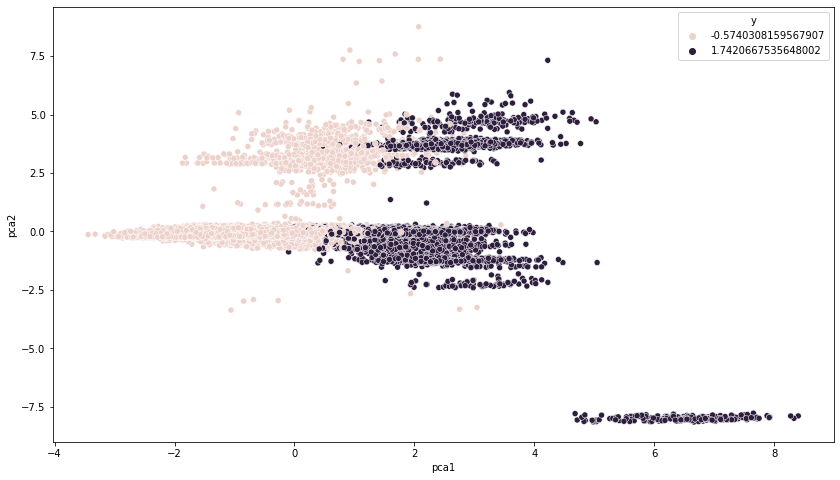

In [6]:
plt.figure(figsize=(14,8))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="y",
    data=num_df,
    legend="full")

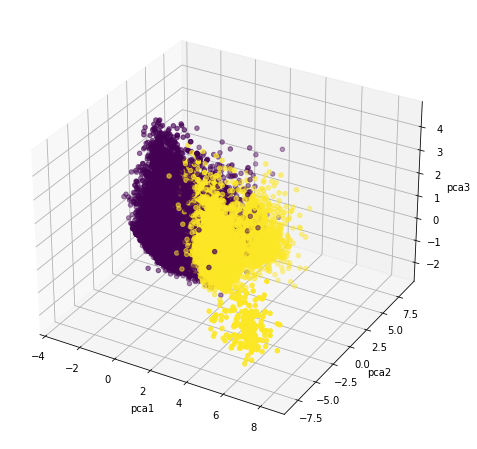

In [7]:
ax = plt.figure(figsize=(14,8)).gca(projection='3d')
ax.scatter(
    xs=num_df["pca1"], 
    ys=num_df["pca2"], 
    zs=num_df["pca3"], 
    c=num_df["y"]
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.show()

## t-SNE

In [8]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(num_df)

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

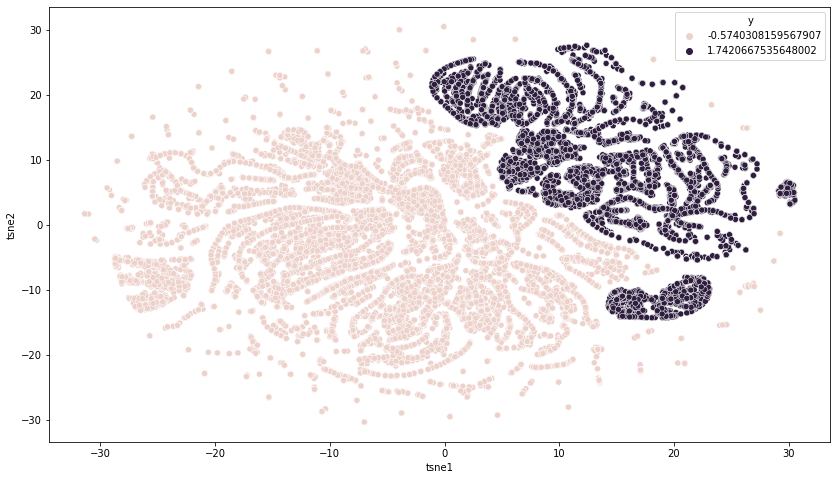

In [9]:
num_df['tsne1'] = tsne_results[:,0]
num_df['tsne2'] = tsne_results[:,1]
plt.figure(figsize=(14,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="y",
    data=num_df,
    legend="full",
)

# 2. Clustering

## 1) Image quantization

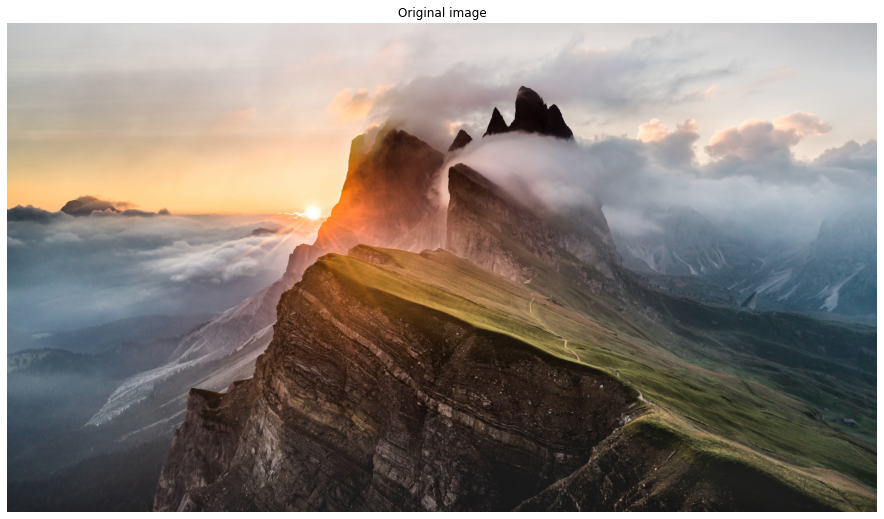

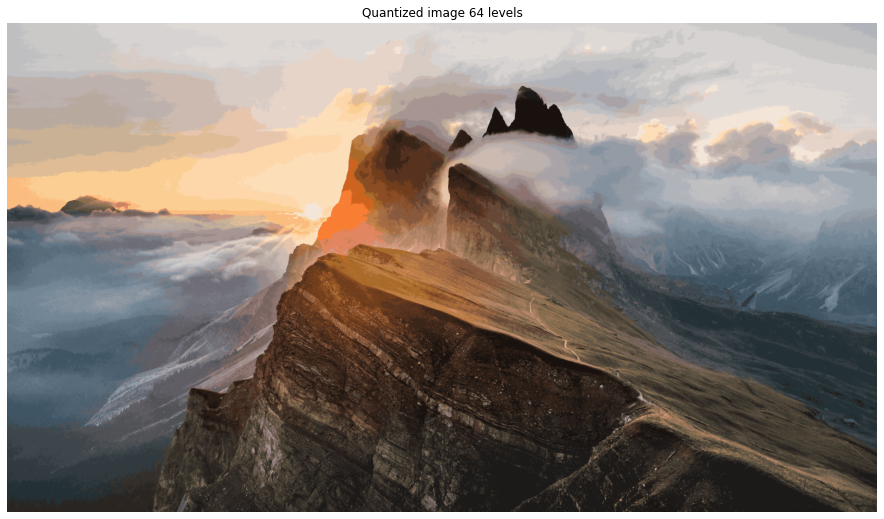

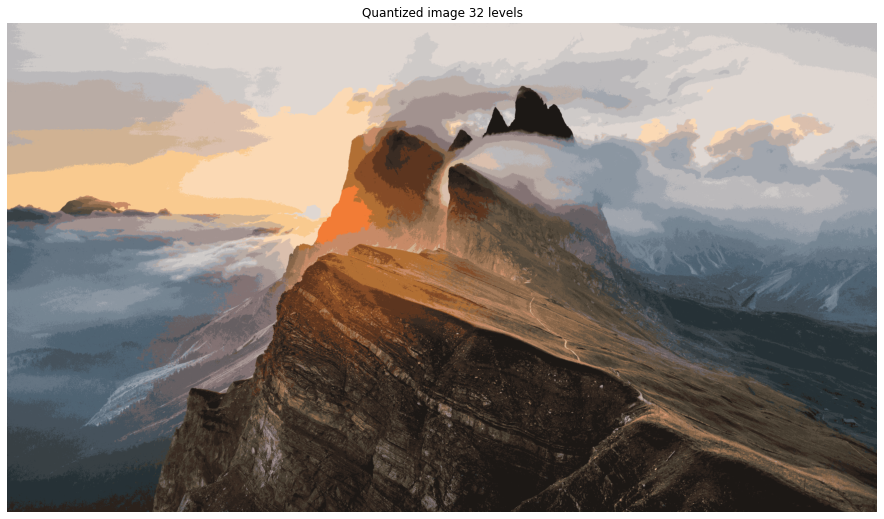

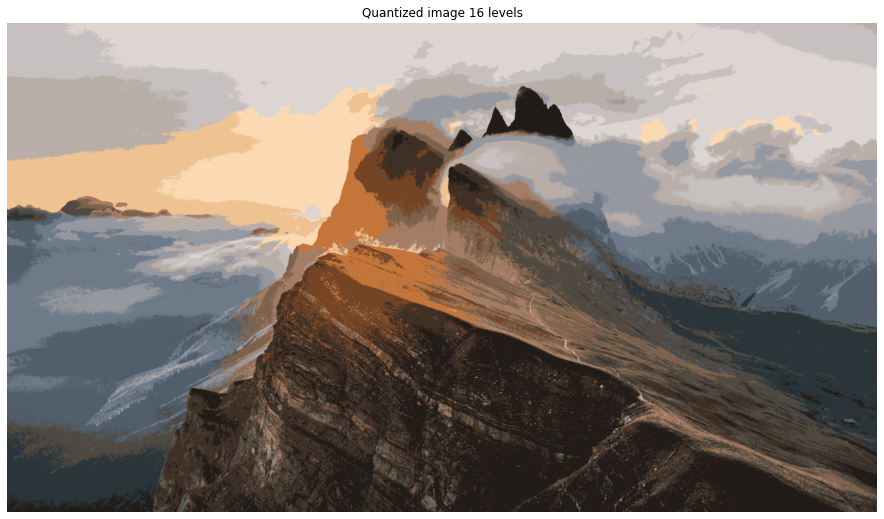

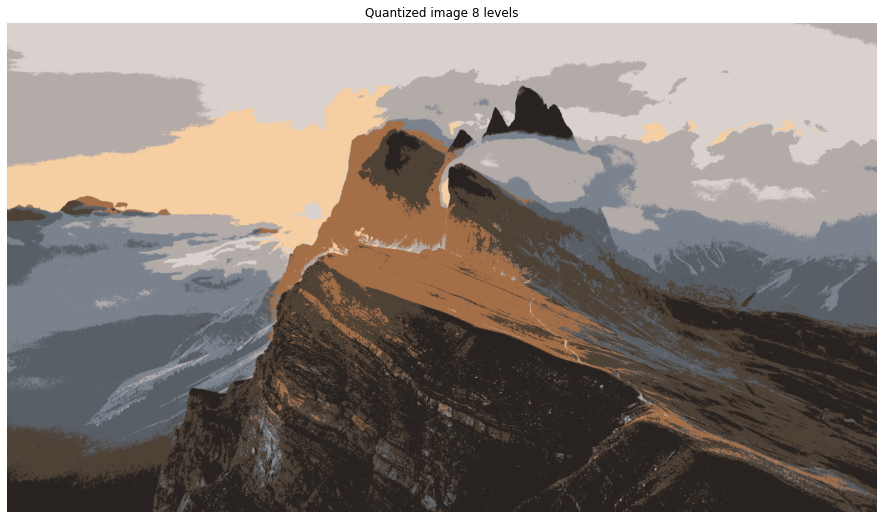

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans


def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


N_COLORS = [64, 32, 16, 8]
SUBSAMPLE_SIZE = 0.01

image = Image.open('img.jpg')
image = np.array(image, dtype=np.float64) / 255

w, h, d = tuple(image.shape)
image_array = np.reshape(image, (w * h, d))
img_subsample = image_array[np.random.choice(w * h, int(w * h * SUBSAMPLE_SIZE)), :]

models = []
for colors in N_COLORS:
    kmeans = KMeans(n_clusters=colors).fit(img_subsample)
    models.append(kmeans)
    
plt.figure(figsize=(16,9))
plt.axis('off')
plt.title('Original image')
plt.imshow(image) 

for model in models:
    labels = model.predict(image_array)
    plt.figure(figsize=(16,9))
    plt.clf()
    plt.axis('off')
    plt.title(f'Quantized image {model.get_params().get("n_clusters")} levels')
    plt.imshow(recreate_image(model.cluster_centers_, labels, w, h))

## 2) Silhouette analysis

For n_clusters = 4 The average silhouette_score is : 0.5830422035169395
For n_clusters = 5 The average silhouette_score is : 0.5740089825824137
For n_clusters = 6 The average silhouette_score is : 0.5206045531413668


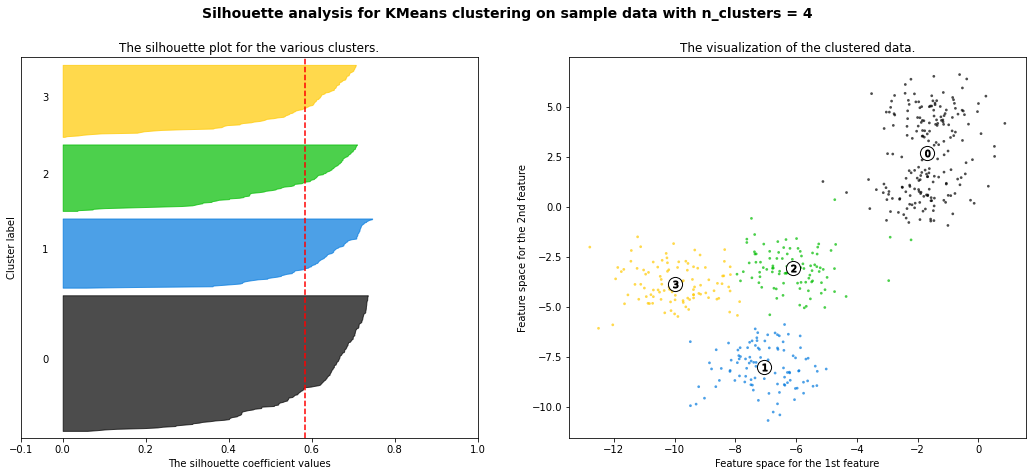

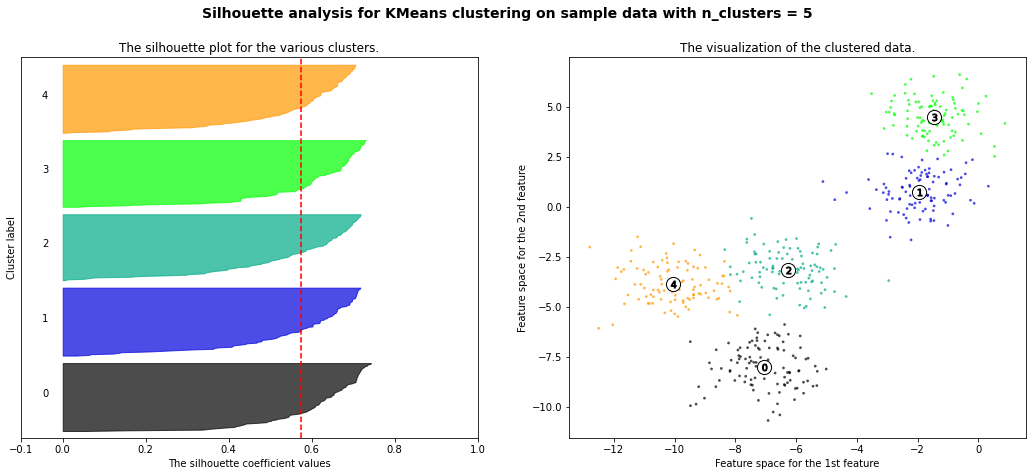

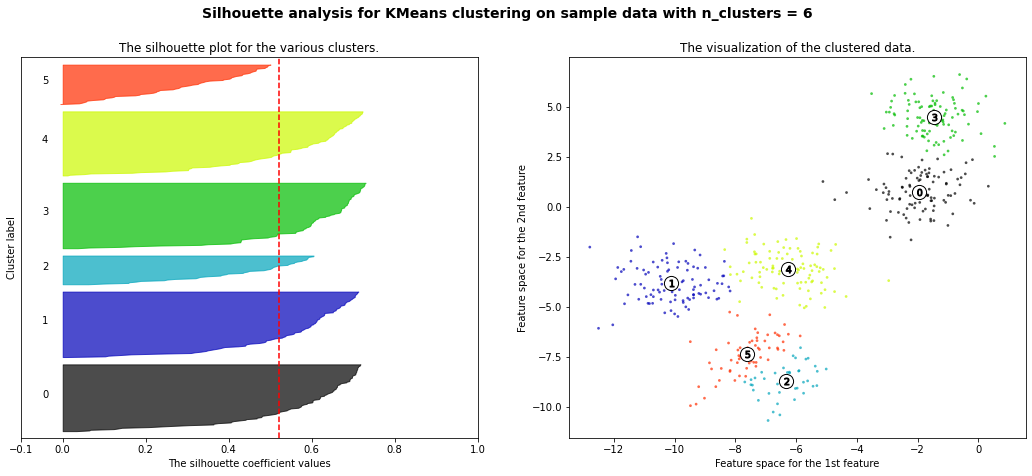

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=5,
                  shuffle=True,
                  random_state=1)

range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

silhouette plot показывает насколько точки кластера ближе к точкам своего кластера чем к точкам другого ближайшего кластера, дополнительно так же показывает размер самого кластера. В данном случае видно что в данных скорее всего не 6 кластеров, так как есть кластер с silhouette coefficient меньше среднего по всем данным, более того, кластеры сильно отличаются по размерам. Варианты 4 и 5 выглядят одинаково приемлимо, так как в кластерах примерно одинаковой формы графики распределения silhouette coefficient. 5 кластеров выигрывают только тем, что имеют одинаковый размер кластеров, что, впрочем, может и не быть правдой в прикладных задачах.

## 3) EM-algorithm

In [12]:
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
mean1 = [0, 0]
cov1 = [[1, 0],
        [0, 1]]

mean2 = [5, 5]
cov2 = [[3, 0],
        [0, 3]]


x1 = np.random.default_rng().multivariate_normal(mean1, cov1, 1000)
x2 = np.random.default_rng().multivariate_normal(mean2, cov2, 1000)
df = np.vstack([x1,x2])

In [14]:
gm = GaussianMixture(n_components=2, covariance_type='diag')
labels = gm.fit_predict(df)

<AxesSubplot:>

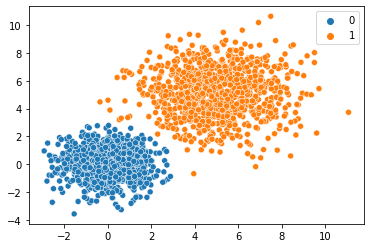

In [15]:
sns.scatterplot(x=df[:,0], y=df[:,1], hue=labels)

### Recreating distributions

In [16]:
gm.covariances_[0]

array([1.05448344, 1.04804545])

In [17]:
x1 = np.random.default_rng().multivariate_normal(gm.means_[0], np.diag(gm.covariances_[0]), 1000)
x2 = np.random.default_rng().multivariate_normal(gm.means_[1], np.diag(gm.covariances_[1]), 1000)
df = np.vstack([x1,x2])

<AxesSubplot:>

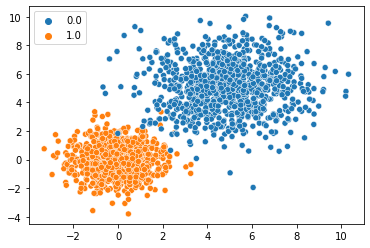

In [18]:
sns.scatterplot(x=df[:,0], y=df[:,1], hue=np.hstack([np.ones((1000)),np.zeros((1000))]))

# 3. NLP

In [19]:
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pd.set_option('max_colwidth', 400)


In [20]:
corpus = pd.read_csv('clickbait_data.csv')

## 1) Data cleaning

In [21]:
corpus

headline  \
0                                                                                        Should I Get Bings   
1                                                             Which TV Female Friend Group Do You Belong In   
2                                 The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills   
3                                       This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect   
4      A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor   
...                                                                                                     ...   
31995                                                   To Make Female Hearts Flutter in Iraq, Throw a Shoe   
31996                                             British Liberal Democrat Patsy Calton, 56, dies of cancer   
31997                           Drone smartphone app to help heart attack victims in remote areas announced   
31998                                            Netanyahu Urges Pope Benedict, in Israel, to Denounce Iran   
31999                                               Computer Makers Prepare to Stake Bigger Claim in Phones   

       clickbait  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
31995          0  
31996          0  
31997          0  
31998          0  
31999          0  

[32000 rows x 2 columns]

Lowercase and leading/trailing whitespaces

In [22]:
corpus['headline'] = corpus['headline'].str.lower()
corpus['headline'] = corpus['headline'].str.strip()

Replace numbers with tokens

In [23]:
corpus['headline'] = corpus['headline'].str.replace('\d+','NUMBER', regex=True)

Removing stop-words

In [24]:
stop_words = stopwords.words('english')

In [25]:
corpus['headline'] = corpus['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Removing punctuation

In [26]:
table = str.maketrans('', '', string.punctuation)
corpus['headline'] = corpus['headline'].str.translate(table)

Lemmatization

In [27]:
lemmatizer = WordNetLemmatizer()
corpus['headline'] = corpus['headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [28]:
corpus

headline  \
0                                                                get bings   
1                                            tv female friend group belong   
2                            new star war force awakens trailer give chill   
3                      vine new york celebrity big brother fucking perfect   
4         couple stunning photo shoot baby learning inoperable brain tumor   
...                                                                    ...   
31995                            make female heart flutter iraq throw shoe   
31996               british liberal democrat patsy calton NUMBER dy cancer   
31997  drone smartphone app help heart attack victim remote area announced   
31998                    netanyahu urge pope benedict israel denounce iran   
31999                      computer maker prepare stake bigger claim phone   

       clickbait  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
31995          0  
31996          0  
31997          0  
31998          0  
31999          0  

[32000 rows x 2 columns]

## 2) Visualization

In [29]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

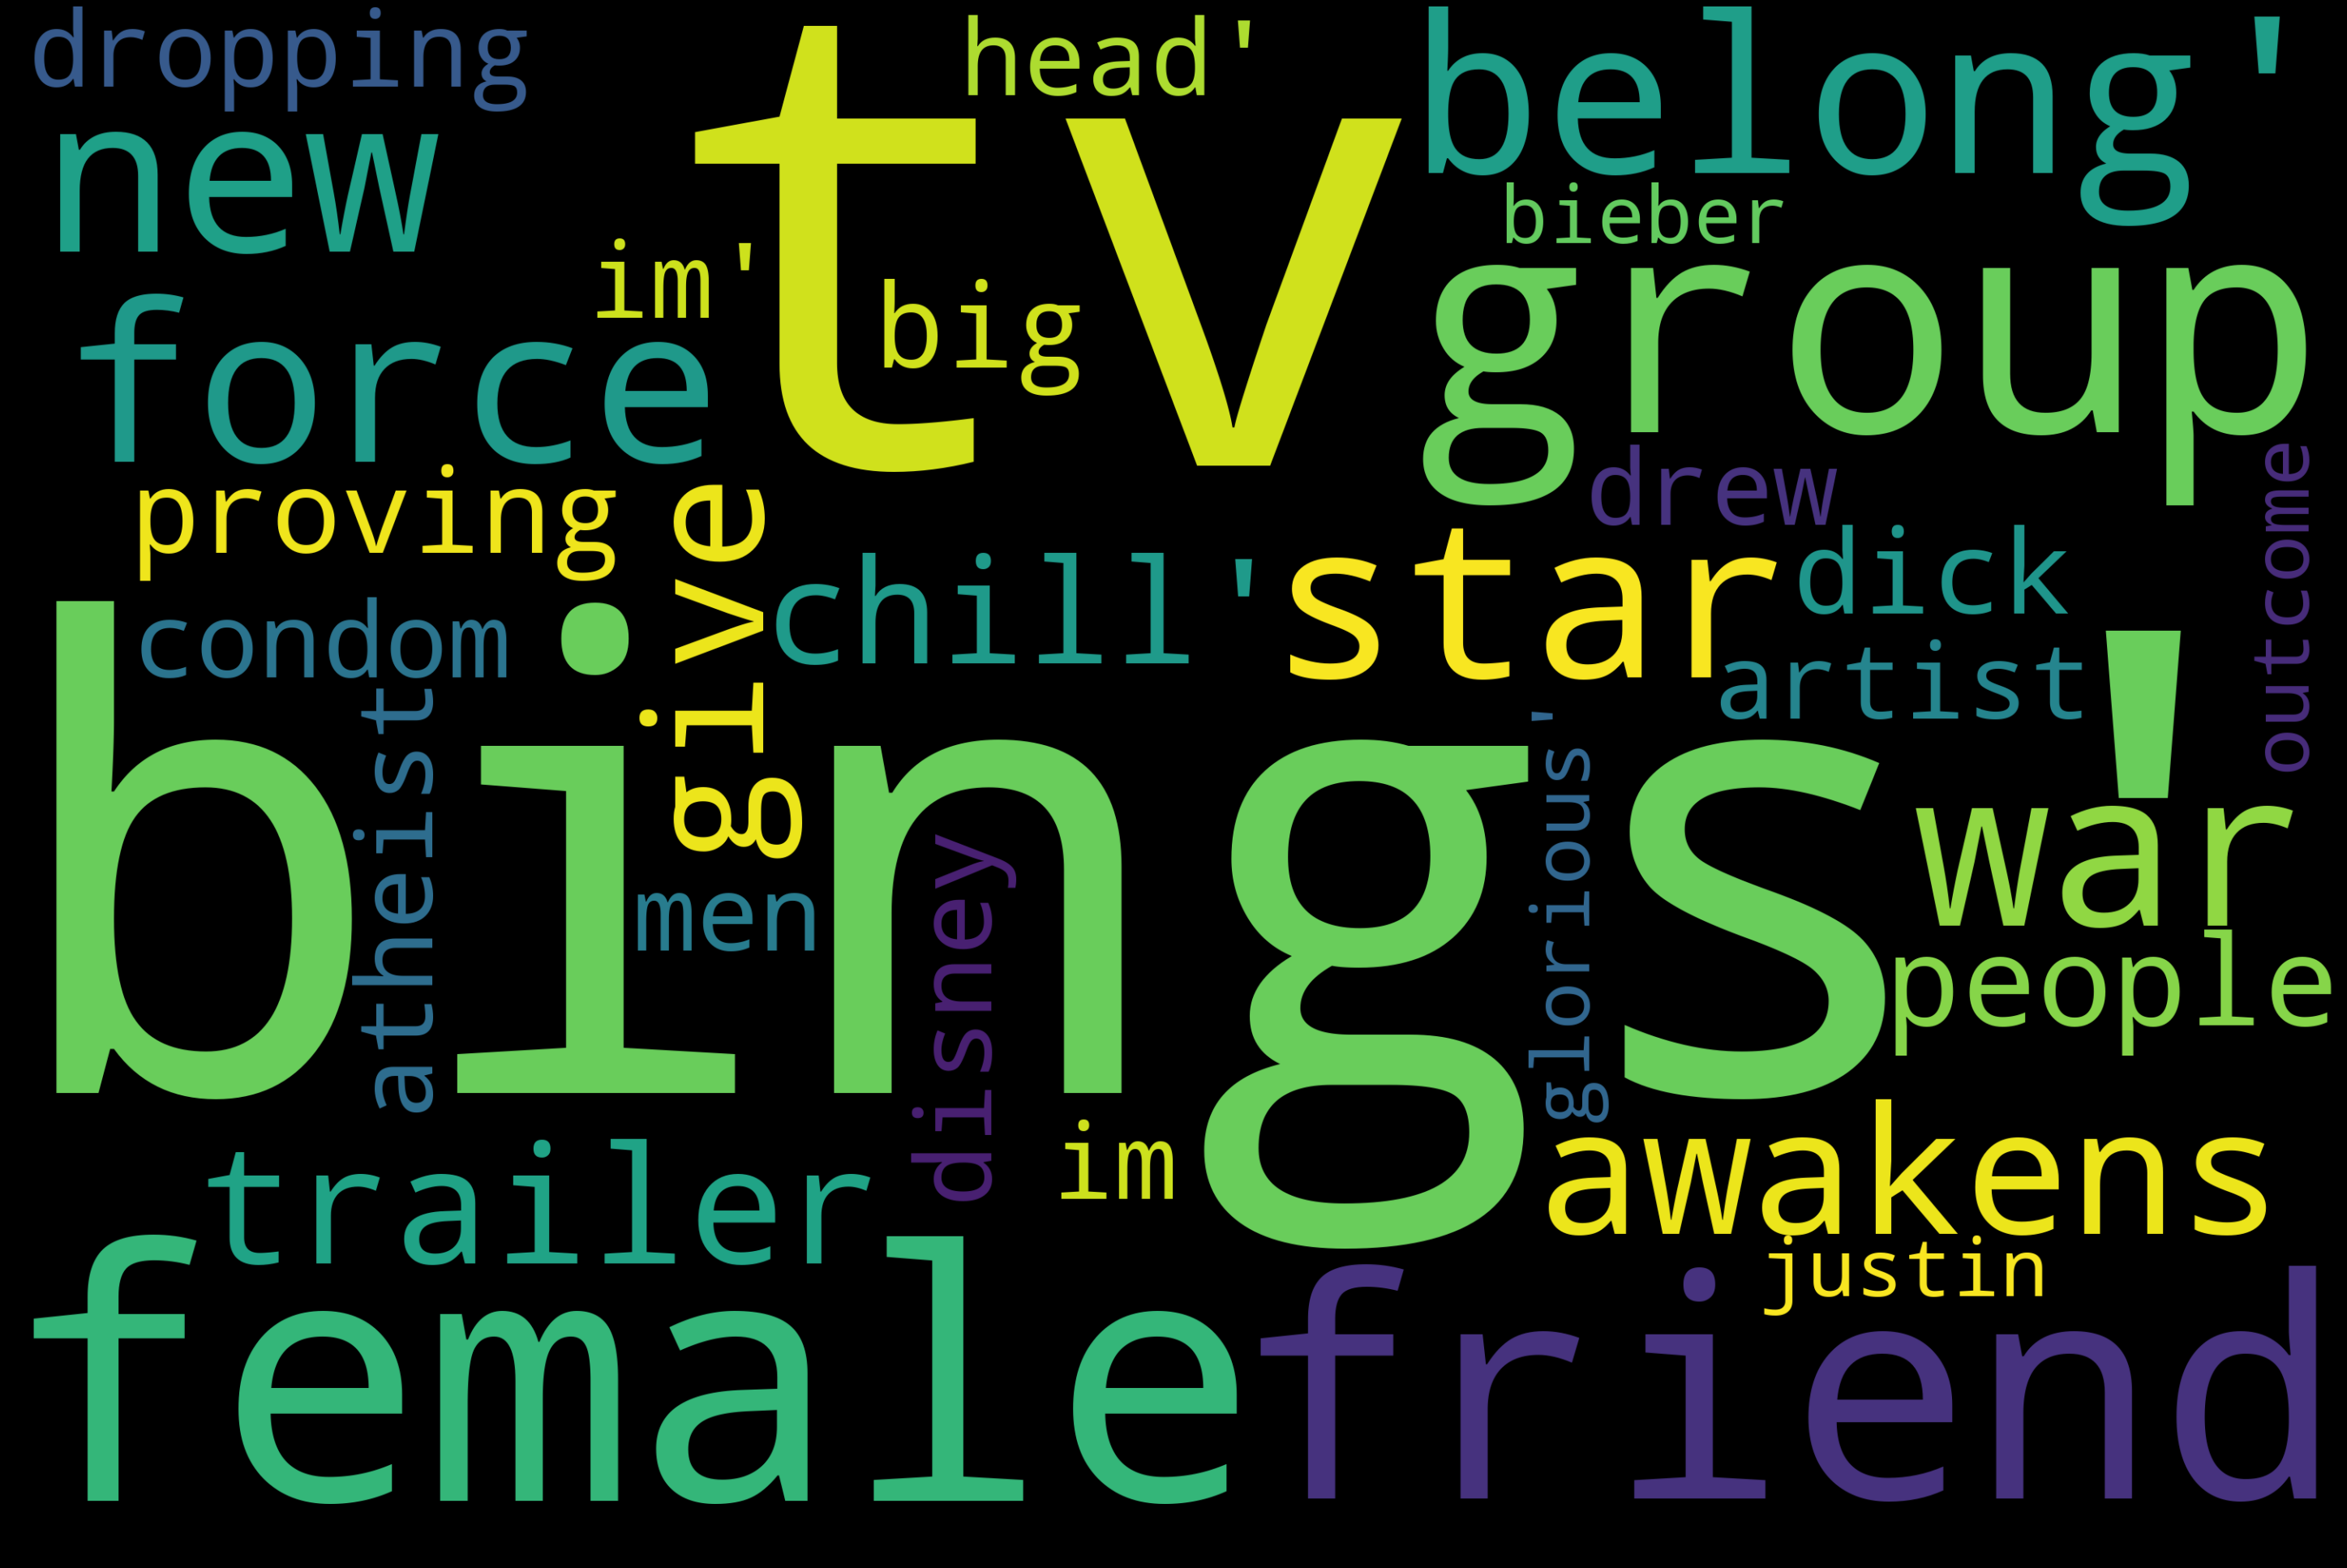

In [30]:
generate_word_cloud(corpus[corpus['clickbait']==1].headline.values)

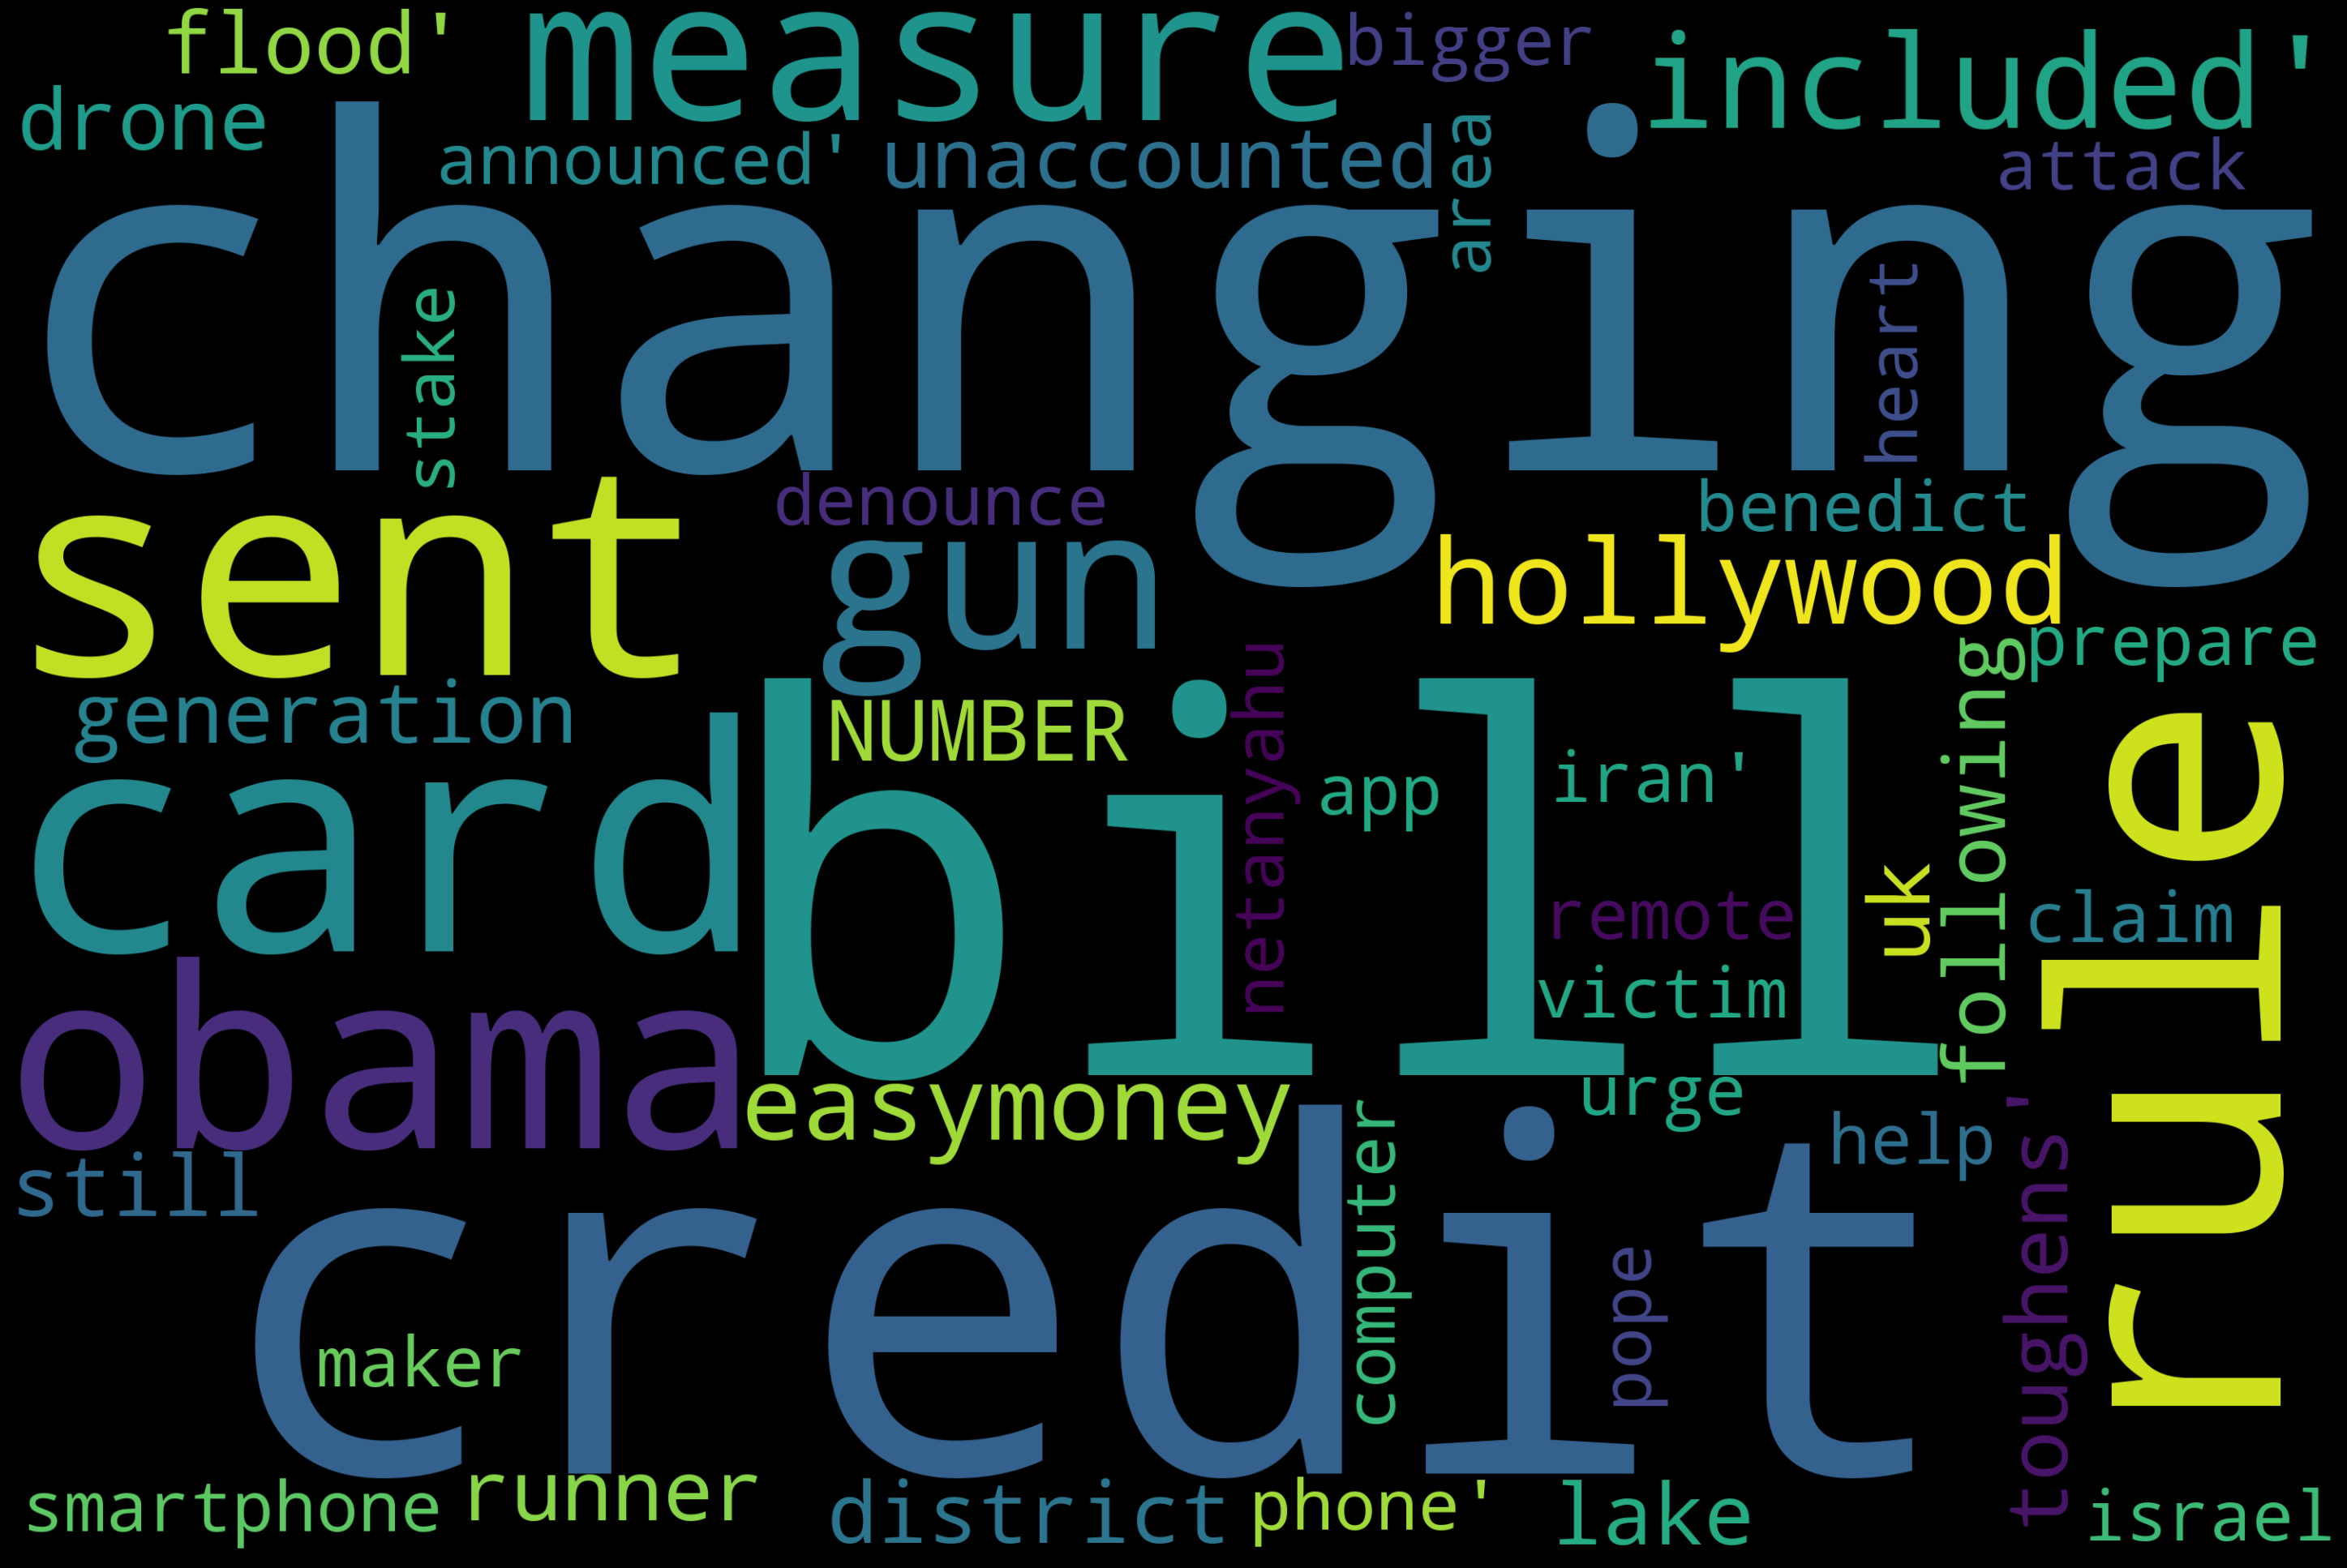

In [31]:
generate_word_cloud(corpus[corpus['clickbait']==0].headline.values)

## 3) Feature extraction

In [32]:
X = TfidfVectorizer(max_features=8000).fit_transform(corpus['headline'])
y = corpus['clickbait']

## 4) Classification

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.97%
